# 0. Install and Import Dependencies

In [89]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [90]:
tf.config.list_physical_devices('GPU')

[]

In [91]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [4]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [7]:
char_to_num.get_vocabulary()

['',
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z'),
 np.str_("'"),
 np.str_('?'),
 np.str_('!'),
 np.str_('1'),
 np.str_('2'),
 np.str_('3'),
 np.str_('4'),
 np.str_('5'),
 np.str_('6'),
 np.str_('7'),
 np.str_('8'),
 np.str_('9'),
 np.str_(' ')]

In [92]:
char_to_num(['a','y','a','z'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 25,  1, 26])>

In [94]:
num_to_char([1, 25, 1, 26])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'y', b'a', b'z'], dtype=object)>

In [10]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join(r'C:\Users\91951\Desktop\LipNet-main\data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join(r'C:\Users\91951\Desktop\LipNet-main\data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [12]:
test_path = r'C:\Users\91951\Desktop\LipNet-main\data\s1\bbal6n.mpg'

In [13]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [14]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

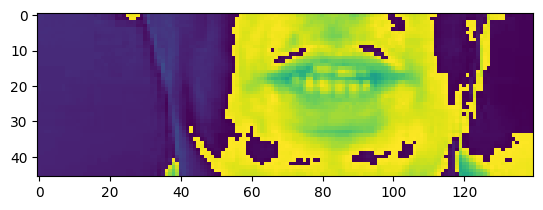

In [15]:
plt.imshow(frames[40])

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [17]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [18]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [19]:
from matplotlib import pyplot as plt

In [20]:
data = tf.data.Dataset.list_files(r'C:\Users\91951\Desktop\LipNet-main\data\s1\*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [21]:
len(test)

50

In [22]:
frames, alignments = data.as_numpy_iterator().next()

In [23]:
len(frames)

2

In [24]:
sample = data.as_numpy_iterator()

In [25]:
val = sample.next(); val[0]

array([[[[[ 1.3826326 ],
          [ 1.3826326 ],
          [ 1.341967  ],
          ...,
          [ 0.243994  ],
          [ 0.121997  ],
          [ 0.121997  ]],

         [[ 1.4232984 ],
          [ 1.4232984 ],
          [ 1.3826326 ],
          ...,
          [ 0.243994  ],
          [ 0.121997  ],
          [ 0.121997  ]],

         [[ 1.3826326 ],
          [ 1.3826326 ],
          [ 1.341967  ],
          ...,
          [ 0.243994  ],
          [ 0.121997  ],
          [ 0.121997  ]],

         ...,

         [[ 0.975976  ],
          [ 0.9353103 ],
          [ 0.9353103 ],
          ...,
          [10.32908   ],
          [10.32908   ],
          [10.32908   ]],

         [[ 0.9353103 ],
          [ 0.9353103 ],
          [ 0.9353103 ],
          ...,
          [10.288414  ],
          [10.288414  ],
          [10.288414  ]],

         [[ 0.9353103 ],
          [ 0.9353103 ],
          [ 0.9353103 ],
          ...,
          [10.288414  ],
          [10.288414  ],
          

In [26]:
# Convert to proper format for imageio
frames_for_gif = (val[0][0].squeeze() * 255).astype('uint8')
imageio.mimsave('./animation.gif', frames_for_gif, fps=10)

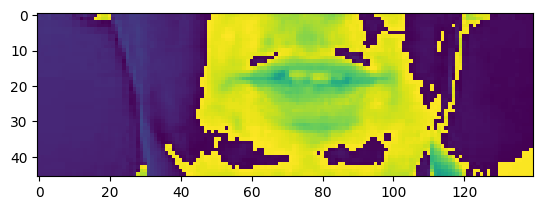

In [ ]:
plt.imshow(val[0][0][35])

In [28]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue with e five soon'>

# 3. Design the Deep Neural Network

In [59]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [60]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [61]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

c:\Users\91951\Desktop\again\vlip\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
5*17*75

6375

In [64]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [65]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'999999999999999999999999999999999999999999999999999999999999999999999rr'>

In [66]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'999999999999999999999999999999999999999999999999999999999999999999999rr'>

In [67]:
model.input_shape

(None, 75, 46, 140, 1)

In [68]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [69]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [70]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [71]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [72]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [73]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [74]:
schedule_callback = LearningRateScheduler(scheduler)

In [75]:
example_callback = ProduceExample(test)

In [76]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100



KeyboardInterrupt: 

# 5. Make a Prediction 

In [77]:
model.load_weights(r'C:\Users\91951\Desktop\LipNet-main\checkpoint.weights.h5')

In [78]:
test_data = test.as_numpy_iterator()

In [79]:
sample = test_data.next()

In [80]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [81]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white by y zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red with l seven again'>]

In [82]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [83]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b' place white by y zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b' lay red with l seven again'>]

# Test on a Video

In [84]:
sample = load_data(tf.convert_to_tensor(r'C:\Users\91951\Desktop\LipNet-main\data\s1\bras9a.mpg'))

In [85]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [86]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [87]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [88]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b' bin red at s nine again'>]